### Dependencies

In [1]:
## Its possible that you will need these installations
!pip install openpyxl
#!pip install tensorflow
#!pip install tensorflow_probability
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Files

In [2]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

### Convert Excel --> CSV

In [3]:
# Read Excel file
excel_file = pd.read_excel('simulation_data.xlsx')

# Convert to CSV
csv_file = 'simulation_data.csv'
excel_file.to_csv(csv_file, index=False)

print(f"Excel file converted to CSV: {csv_file}")

Excel file converted to CSV: simulation_data.csv


### Preview the Data

In [4]:
df = pd.read_csv(csv_file)
print(df)

    Observations  Obesity Hypertension Alcohol Consumption per Day
0             38      Low           No                    0 Drinks
1             34      Low           No                  1-2 Drinks
2             31      Low           No                  3-5 Drinks
3             22      Low           No                   6+ Drinks
4              5      Low          Yes                    0 Drinks
5              9      Low          Yes                  1-2 Drinks
6              8      Low          Yes                  3-5 Drinks
7             10      Low          Yes                   6+ Drinks
8             31  Average           No                    0 Drinks
9             23  Average           No                  1-2 Drinks
10            35  Average           No                  3-5 Drinks
11            30  Average           No                   6+ Drinks
12             6  Average          Yes                    0 Drinks
13             9  Average          Yes                  1-2 Dr

### Calculate the Beta_Hat's and the Covariance Matrix

In [5]:
# Perform one-hot encoding on relevant columns
one_hot_encoded_data = pd.get_dummies(df, columns=['Obesity', 'Hypertension', 'Alcohol Consumption per Day'])

# Select the desired columns for the result
result_columns = ['Obesity_Average', 'Obesity_High', 'Hypertension_Yes',
                  'Alcohol Consumption per Day_1-2 Drinks', 'Alcohol Consumption per Day_3-5 Drinks', 'Alcohol Consumption per Day_6+ Drinks']
result_data = one_hot_encoded_data[result_columns]

# Convert the result dataframe to a numpy array
matrix = result_data.to_numpy()

# Convert True and False to 1 and 0
matrix = matrix.astype(int)

# Add an intercept column of ones
intercept_column = np.ones((matrix.shape[0], 1), dtype=int)
matrix = np.hstack((intercept_column, matrix))

# Print the matrix with clear 1s and 0s
np.set_printoptions(edgeitems=3, formatter={'int': '{:3d}'.format})
print(matrix)

# observations
y = df['Observations']

[[  1   0   0   0   0   0   0]
 [  1   0   0   0   1   0   0]
 [  1   0   0   0   0   1   0]
 [  1   0   0   0   0   0   1]
 [  1   0   0   1   0   0   0]
 [  1   0   0   1   1   0   0]
 [  1   0   0   1   0   1   0]
 [  1   0   0   1   0   0   1]
 [  1   1   0   0   0   0   0]
 [  1   1   0   0   1   0   0]
 [  1   1   0   0   0   1   0]
 [  1   1   0   0   0   0   1]
 [  1   1   0   1   0   0   0]
 [  1   1   0   1   1   0   0]
 [  1   1   0   1   0   1   0]
 [  1   1   0   1   0   0   1]
 [  1   0   1   0   0   0   0]
 [  1   0   1   0   1   0   0]
 [  1   0   1   0   0   1   0]
 [  1   0   1   0   0   0   1]
 [  1   0   1   1   0   0   0]
 [  1   0   1   1   1   0   0]
 [  1   0   1   1   0   1   0]
 [  1   0   1   1   0   0   1]]


In [6]:
poisson_model = sm.GLM(y, matrix, family=sm.families.Poisson())  # Fit the Poisson GLM
results = poisson_model.fit()

beta_hat = results.params
cov_matrix_hat = results.cov_params()

print(beta_hat)
print(cov_matrix_hat.shape)

const    3.289832
x1       0.012658
x2       0.049700
x3      -0.982736
x4      -0.008889
x5       0.155414
x6       0.092894
dtype: float64
(7, 7)


### Random Walk Metropolis

In [7]:
def pi(b, matrix, obs):
    '''

    Density of the target distribution, up to a constant.

    x -- np array of size k
    V -- np array of size k*k
    '''
    result = 0
    for i in range(matrix.shape[0]):
        mi = matrix[i] @ b
        result += -np.e**mi + obs[i]*mi

    return result

In [8]:
# define the proposal distribution
def q(x, cov):
    '''
    Random proposition for the Metropolis-Hastings algorithm.
    Uses the multivariate normal distribution with mean x and covariance cov.

    x -- np array of size k
    '''
    return np.random.multivariate_normal(x, 1.02*cov)

In [9]:
def random_walk_metropolis(N, x0, matrix, obs, cov, burn_in, thinning):
    x = x0
    chain = np.zeros([N, 7])

    counter_thin = 0
    sample_size = 0
    counter = 0
    accept = 0
    while sample_size < N:
        y = q(x, cov)
        ratio = pi(y, matrix, obs) - pi(x, matrix, obs)
        a = np.min([0,ratio])
        r = np.random.rand()
        if np.log(r) < a:
            x = y
            accept += 1
        # this is responsible for gathering samples in harmony with the rules set by burnin/thinning
        if counter>burn_in and (counter_thin == thinning or sample_size == 0):
            counter_thin = 0
            chain[sample_size] = x
            sample_size+= 1
        counter_thin += 1
        counter += 1
    acceptance_rate = accept/counter
    return chain, acceptance_rate

In [10]:
burn_in = 1000
thinning = 10
num_samples = 1000
cov = np.array(cov_matrix_hat)
mean = np.array(beta_hat)
observations = np.array(y)
initial_point = [1, 2, 3, 4, 5, 6, 7]
chain, acceptance_rate = random_walk_metropolis(num_samples, initial_point, matrix, observations, cov, burn_in, thinning)
sample_mean = np.mean(chain, axis = 0)
sample_std = np.std(chain, axis = 0)

print("The true mean is: {}".format(np.around(mean, decimals=2)))

print("The simulated mean is: {}".format(np.around(sample_mean, decimals=2)))

print("The simulated standard deviation is: {}".format(np.around(sample_std, decimals=2)))

print("The acceptance rate is: {}".format(np.around(acceptance_rate, decimals=2)))

The true mean is: [ 3.29  0.01  0.05 -0.98 -0.01  0.16  0.09]
The simulated mean is: [ 3.29  0.    0.03 -0.98 -0.01  0.16  0.09]
The simulated standard deviation is: [0.12 0.11 0.11 0.1  0.13 0.13 0.12]
The acceptance rate is: 0.23


### The Histograms of Random Walk for each Beta_Hat

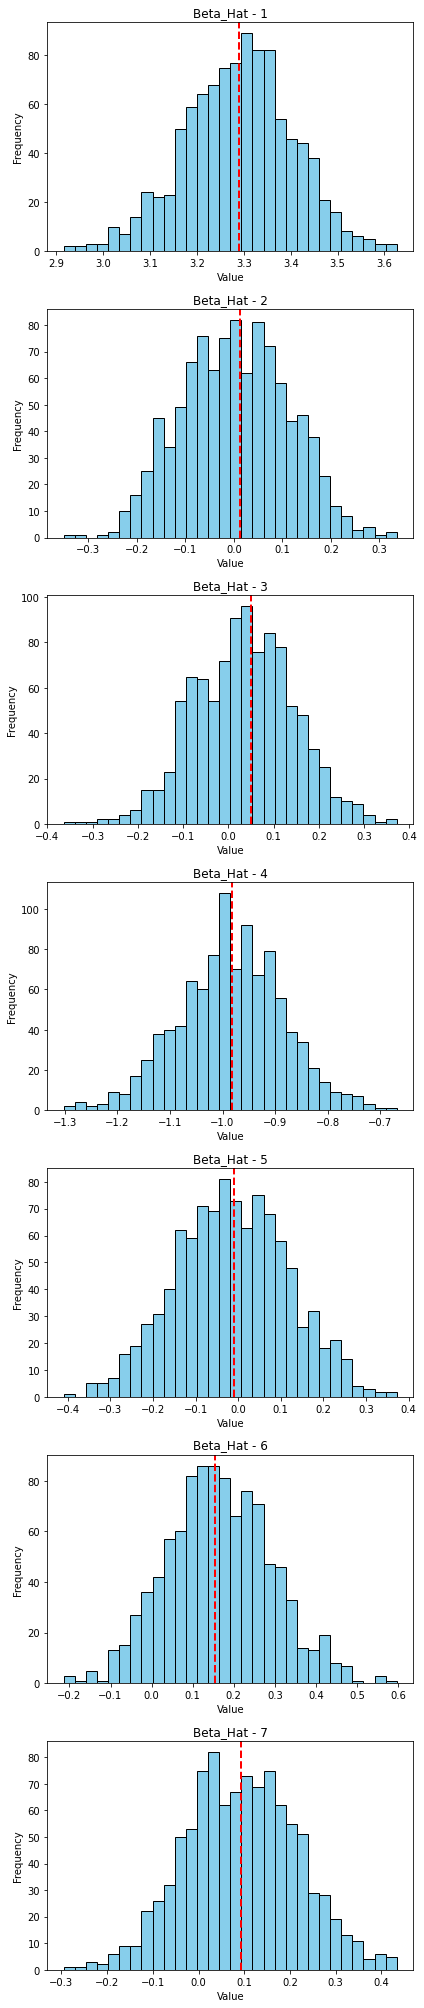

In [11]:
# Get the number of dimensions
num_dimensions = chain.shape[1]

# Create a figure with subplots for each dimension
fig, axes = plt.subplots(nrows=num_dimensions, ncols=1, figsize=(6, num_dimensions*4))

# Iterate over each dimension
for i in range(num_dimensions):
    # Get the samples for the current dimension
    dimension_samples = chain[:, i]

    # Plot the histogram
    axes[i].hist(dimension_samples, bins=30, color='skyblue', edgecolor='black')

    # Add a vertical line for the true value
    axes[i].axvline(x=beta_hat[i], color='red', linestyle='--', linewidth=2)

    # Set the plot title and labels
    axes[i].set_title(f'Beta_Hat - {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Random Walk Convergence Chains

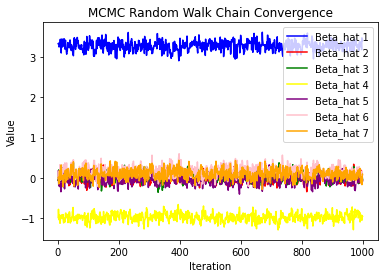

In [12]:
# Generate an array of iteration numbers
iterations = np.arange(1, num_samples + 1)

# Plot the convergence of the chain
plt.plot(iterations, chain[:, 0], color='blue', label='Beta_hat 1')
plt.plot(iterations, chain[:, 1], color='red', label='Beta_hat 2')
plt.plot(iterations, chain[:, 2], color='green', label='Beta_hat 3')
plt.plot(iterations, chain[:, 3], color='yellow', label='Beta_hat 4')
plt.plot(iterations, chain[:, 4], color='purple', label='Beta_hat 5')
plt.plot(iterations, chain[:, 5], color='pink', label='Beta_hat 6')
plt.plot(iterations, chain[:, 6], color='orange', label='Beta_hat 7')
# Add more lines for additional dimensions

# Set the plot title and labels
plt.title('MCMC Random Walk Chain Convergence')
plt.xlabel('Iteration')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()


### The Autocorrelation Chains

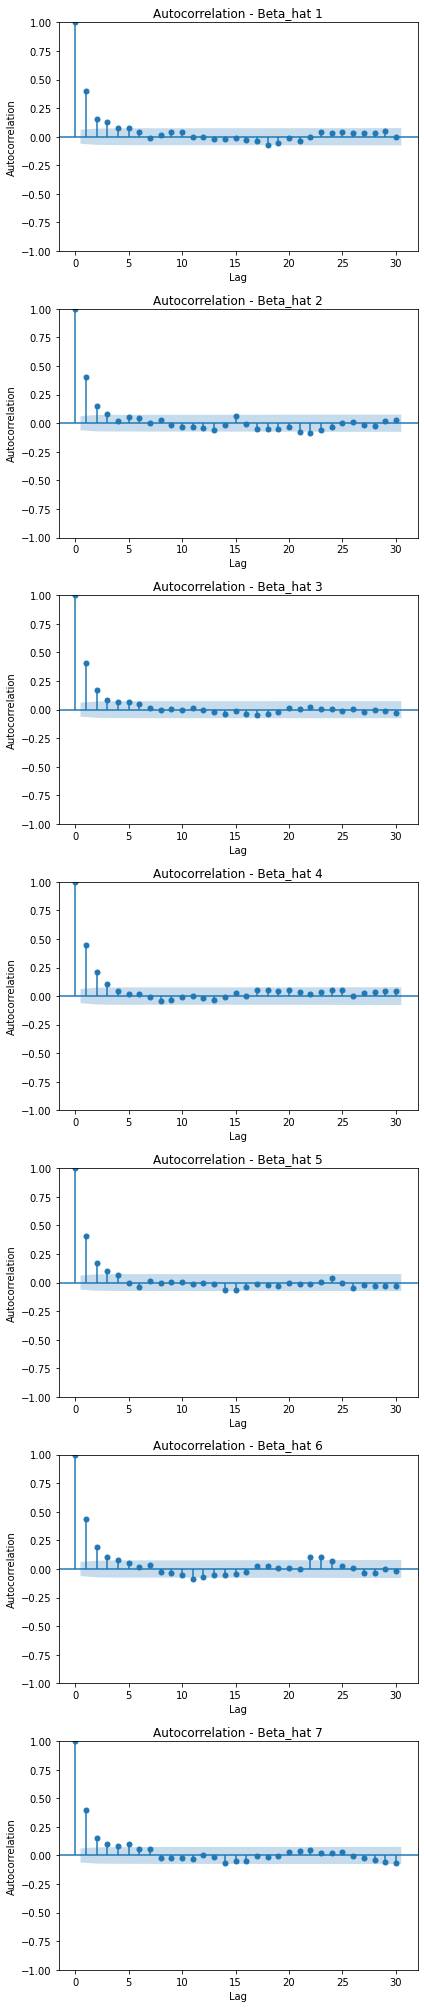

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation for each dimension
fig, axes = plt.subplots(nrows=num_dimensions, ncols=1, figsize=(6, num_dimensions*4))

# Iterate over each dimension
for i in range(num_dimensions):
    # Get the samples for the current dimension
    dimension_samples = chain[:, i]

    # Plot the autocorrelation
    plot_acf(dimension_samples, ax=axes[i])

    # Set the plot title and labels
    axes[i].set_title(f'Autocorrelation - Beta_hat {i+1}')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Autocorrelation')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Effective Sample Size Calculation

In [14]:
### Effective Sample Size for Random Walk Metropolis
#import tensorflow_probability as tfp
#import tensorflow as tf

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#ess = tfp.mcmc.effective_sample_size(chain)[0]

#print(int(ess.numpy()))

#493